<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/fish.jpg" width="280px"></div>

## Anomaly Exploration (understanding 'Odd')
In this notebook we're going to be using the zat Python module for processing, transformation and anomaly detection on Zeek network data. We're going to look at 'normal' http traffic and demonstrate the use of Isolation Forests for anomaly detection. We'll then explore those anomalies with clustering and PCA.

**Software**
- zat: https://github.com/SuperCowPowers/zat
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

**Techniques**
- One Hot Encoding: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- Isolation Forest: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- PCA: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Related Notebooks**
- Zeek to Scikit-Learn: https://nbviewer.jupyter.org/github/SuperCowPowers/zat/blob/master/notebooks/Zeek_to_Scikit_Learn.ipynb

**Note:** A previous version of this notebook used a large http log (1 million rows) but we wanted people to be able to run the notebook themselves, so we've changed it to run on the local example http.log.

In [1]:
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
print('zat: {:s}'.format(zat.__version__))
import pandas as pd
print('Pandas: {:s}'.format(pd.__version__))
import numpy as np
print('Numpy: {:s}'.format(np.__version__))
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
print('Scikit Learn Version:', sklearn.__version__)

zat: 0.4.4
Pandas: 1.0.4
Numpy: 1.18.5
Scikit Learn Version: 0.22.2.post1


In [2]:
# Create a Pandas dataframe from the Zeek HTTP log
log_to_df = LogToDataFrame()
zeek_df = log_to_df.create_dataframe('http.log')
print('Read in {:d} Rows...'.format(len(zeek_df)))
zeek_df.head()

Read in 150 Rows...


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,referrer,...,info_msg,filename,tags,username,password,proxied,orig_fuids,orig_mime_types,resp_fuids,resp_mime_types
ts,,,,,,,,,,,,,,,,,,,,,
2013-09-15 23:44:27.668081999,CyIaMO7IheOh38Zsi,192.168.33.10,1031,54.245.228.191,80,1,GET,guyspy.com,/,NaN,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,Fnjq3r4R0VGmHVWiN5,text/html
2013-09-15 23:44:27.731701851,CoyZrY2g74UvMMgp4a,192.168.33.10,1032,54.245.228.191,80,1,GET,www.guyspy.com,/,NaN,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FCQ5aX37YzsjAKpcv8,text/html
2013-09-15 23:44:28.092921972,CoyZrY2g74UvMMgp4a,192.168.33.10,1032,54.245.228.191,80,2,GET,www.guyspy.com,/wp-content/plugins/slider-pro/css/advanced-sl...,http://www.guyspy.com/,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FD9Xu815Hwui3sniSf,text/html
2013-09-15 23:44:28.150300980,CiCKTz4e0fkYYazBS3,192.168.33.10,1040,54.245.228.191,80,1,GET,www.guyspy.com,/wp-content/plugins/contact-form-7/includes/cs...,http://www.guyspy.com/,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FMZXWm1yCdsCAU3K9d,text/plain
2013-09-15 23:44:28.150601864,C1YBkC1uuO9bzndRvh,192.168.33.10,1041,54.245.228.191,80,1,GET,www.guyspy.com,/wp-content/plugins/slider-pro/css/slider/adva...,http://www.guyspy.com/,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FA4NM039Rf9Y8Sn2Rh,text/plain


<div style="float: left; margin: 20px -10px 0px -40px"><img src="images/confused.jpg" width="200px"></div>
<div style="float: right; margin: 20px -10px 0px -10px"><img src="images/pandas.png" width="300px"></div>
## So... what just happened?
**Yep it was quick... the two little lines of code above turned a Zeek log (any log) into a Pandas DataFrame. The zat package also supports streaming data from dynamic/active logs, handles log rotations and in general tries to make your life a bit easier when doing data analysis and machine learning on Zeek data.**

**Now that we have the data in a dataframe there are a million wonderful things we could do for data munging, processing and analysis but that will have to wait for another time/notebook.**

In [3]:
# We're going to pick some features that might be interesting
# some of the features are numerical and some are categorical
features = ['id.resp_p', 'method', 'resp_mime_types', 'request_body_len']

## Our HTTP features are a mix of numeric and categorical data
When we look at the http records some of the data is numerical and some of it is categorical so we'll need a way of handling both data types in a generalized way. zat has a DataFrameToMatrix class that handles a lot of the details and mechanics of combining numerical and categorical data, we'll use below.

In [4]:
# Show the dataframe with mixed feature types
zeek_df[features].head()

,id.resp_p,method,resp_mime_types,request_body_len
ts,,,,
2013-09-15 23:44:27.668081999,80,GET,text/html,0
2013-09-15 23:44:27.731701851,80,GET,text/html,0
2013-09-15 23:44:28.092921972,80,GET,text/html,0
2013-09-15 23:44:28.150300980,80,GET,text/plain,0
2013-09-15 23:44:28.150601864,80,GET,text/plain,0


<div style="float: right; margin: -10px 40px -10px 40px"><img src="images/transformers.png" width="200px"></div>

## Transformers
**We'll now use a scikit-learn tranformer class to convert the Pandas DataFrame to a numpy ndarray (matrix). Yes it's awesome... I'm not sure it's Optimus Prime awesome.. but it's still pretty nice.**

In [5]:
# Use the zat DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix()
zeek_matrix = to_matrix.fit_transform(zeek_df[features], normalize=True)
print(zeek_matrix.shape)
zeek_matrix[:1]

Normalizing column id.resp_p...
Normalizing column request_body_len...
(150, 12)


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [6]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(behaviour='new', contamination=0.25) # Marking 25% odd
odd_clf.fit(zeek_matrix)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=False, contamination=0.25,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [7]:
# Now we create a new dataframe using the prediction from our classifier
odd_df = zeek_df[features][odd_clf.predict(zeek_matrix) == -1]
print(odd_df.shape)
odd_df.head()

(32, 4)


,id.resp_p,method,resp_mime_types,request_body_len
ts,,,,
2013-09-15 23:44:47.464160919,80,GET,application/x-dosexec,0
2013-09-15 23:44:47.464160919,80,GET,application/x-dosexec,0
2013-09-15 23:44:49.221977949,80,GET,application/x-dosexec,0
2013-09-15 23:44:50.805350065,80,GET,application/x-dosexec,0
2013-09-15 23:44:51.404618979,80,GET,application/x-dosexec,0


In [8]:
# Now we're going to explore our odd dataframe with help from KMeans and PCA algorithms
odd_matrix = to_matrix.fit_transform(odd_df)

Normalizing column id.resp_p...
Normalizing column request_body_len...


In [9]:
# Just some simple stuff for this example, KMeans and PCA
kmeans = KMeans(n_clusters=4).fit_predict(odd_matrix)  # Change this to 3/5 for fun
pca = PCA(n_components=3).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe!
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans
odd_df.head()

,id.resp_p,method,resp_mime_types,request_body_len,x,y,cluster
ts,,,,,,,
2013-09-15 23:44:47.464160919,80,GET,application/x-dosexec,0,1.112838,-0.615773,1
2013-09-15 23:44:47.464160919,80,GET,application/x-dosexec,0,1.112838,-0.615774,1
2013-09-15 23:44:49.221977949,80,GET,application/x-dosexec,0,1.112838,-0.615773,1
2013-09-15 23:44:50.805350065,80,GET,application/x-dosexec,0,1.112838,-0.615774,1
2013-09-15 23:44:51.404618979,80,GET,application/x-dosexec,0,1.112838,-0.615774,1


In [10]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

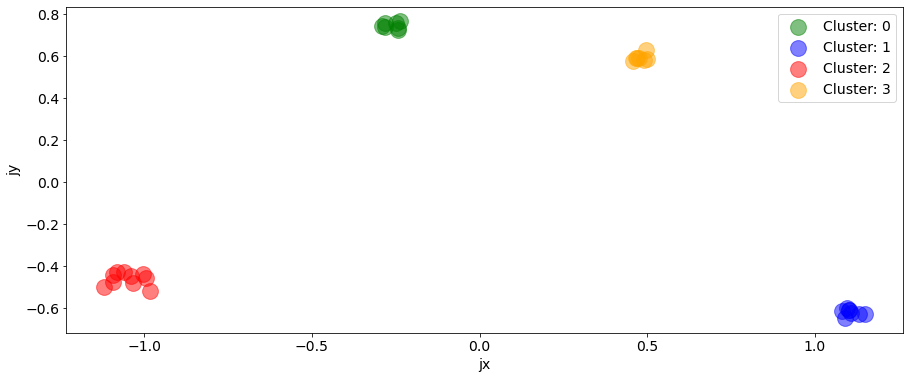

In [11]:
# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [12]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 7 observations
                               id.resp_p   method resp_mime_types  request_body_len
ts                                                                                 
2013-09-15 23:48:06.495719910         80  OPTIONS      text/plain                 0
2013-09-15 23:48:07.495719910         80  OPTIONS      text/plain                 0
2013-09-15 23:48:08.495719910         80  OPTIONS      text/plain                 0
2013-09-15 23:48:08.495719910         80  OPTIONS      text/plain                 0
2013-09-15 23:48:08.495719910         80  OPTIONS      text/plain                 0

Cluster 1: 8 observations
                               id.resp_p method        resp_mime_types  request_body_len
ts                                                                                      
2013-09-15 23:44:47.464160919         80    GET  application/x-dosexec                 0
2013-09-15 23:44:47.464160919         80    GET  application/x-dosexec                 0
20

#### <div style="float: right; margin: 10px 10px 10px 10px"><img src="images/deep_dive.jpeg" width="250px"></div>
## Categorical variables that are anomalous
- Cluster 0: application/x-dosexec mime_types
- Cluster 1: http method of OPTIONS (instead of normal GET/POST)
- Cluster 2: See Below
- Cluster 3: response port of 8080 (instead of 80)

## Numerical variable outliers
- Cluster 2: The request_body_len values are outliers (for this demo dataset)

**The important thing here is that both categorical and numerical variables were properly handled and the machine learning algorithm 'did the right thing' when marking outliers (for categorical and numerical fields)**


For this small demo dataset almost all request_body_len are 0
Cluster 2 represents outliers


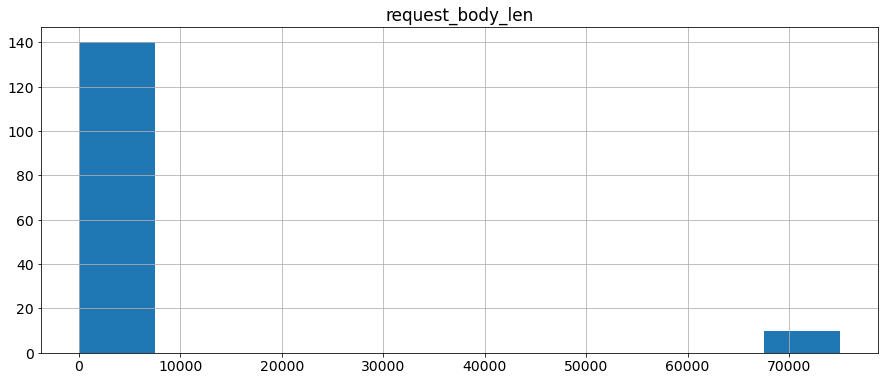

In [14]:
# Distribution of the request body length
zeek_df[['request_body_len']].hist()
print('\nFor this small demo dataset almost all request_body_len are 0\nCluster 2 represents outliers')

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/why_normal.jpg" width="200px"></div>

## The anomalies identified by the model might be fine/expected
Looking at the anomalous clusters for this small demo http log reveals four clusters that may be perfectly fine.  So
here we're not equating anomalous with 'bad'. The use of an anomaly detection algorithm can bring latent issues to the attention of threat hunters and system administrations. The results might be expected or a misconfigured appliance or something more nefarious that needs attention from security.


If you liked this notebook please visit the [zat](https://github.com/SuperCowPowers/zat) project for more notebooks and examples.
